<a href="https://colab.research.google.com/github/jacksone1/DataSci/blob/main/DataSciUnit5ProjectClean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install and import datasets and preliz libraries
!pip install git+https://github.com/pydata/xarray.git
import xarray as xr

!pip install datasets
from datasets import load_dataset

!pip install preliz
import preliz as pz

!pip install numpyro
import numpyro

!pip install bambi
import bambi as bmb

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-37zq2my_
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-37zq2my_
  Resolved https://github.com/pydata/xarray.git to commit 1189240b2631fa27dec0cbea76bf3cf977b42fce
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.3.dev12+g1189240b-py3-none-any.whl size=1249820 sha256=880b0268d6311e9a822f00580bf5d1a048c26c2cdbb7c2d7f1904ed808a49502
  Stored in directory: /tmp/pip-ephem-wheel-cache-mouig9d3/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.2
    Uninstalling xarray-2025.1.2:
      Successfully uninstalled xarray-2025.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.7 MB/s eta 0:00:00
   ━

In [ ]:
#Import other libraries
import numpy as np
import arviz as az
import pymc as pm
import pandas as pd
import random as rd
from matplotlib import pyplot as plt
import seaborn as sns
import xarray as xr
from scipy.interpolate import PchipInterpolator
import pytensor.tensor as pt
from matplotlib.lines import Line2D

In the game Super Mario Maker 2, players design their own Mario levels and share them online for others to play. Each level has a "clear rate," the proportion of level attempts that are successful. Each level is also given its own difficulty value by the game as categorized below. My goal is to predict difficulty as determined by clear rate.

In [ ]:
difficulties = {
    0: "Easy",
    1: "Normal",
    2: "Expert",
    3: "Super expert"
}

The Mario Maker 2 data used for this project was acquired from https://huggingface.co/datasets/TheGreatRambler/mm2_level. The dataset contains a variety of information about player uploaded levels, including the clear rates and difficulties.

The dataset is too large to load quickly in its entirety, so it is loaded in streaming mode, which means only part of the dataset is loaded at a time. 1000 entries of level data are acquired and shuffled, before the clear rate and difficulty of each level is recorded in a dictionary. The dictionary is then converted to a pandas dataframe.

The random seed used for acquiring the data was generated from Random.org's random integer generator from 1 to 100 (both inclusive) at 2024-12-05 18:54:57 UTC

In [ ]:
#Read Mario Maker data
mario_levels = load_dataset("TheGreatRambler/mm2_level", streaming=True, split="train")
#Shuffle data
shuffled_levels = mario_levels.shuffle(buffer_size=1_000, seed=75)
#Get the data as a list to iterate over
sample = list(shuffled_levels.take(1000))
#Create a dictionary to hold difficulties anc clear rate
level_data_dict = {"difficulty": [], "clear_rate": []}
#For each element of the list, record the relevant level data
for i in range(0, 1000):
  level_data_dict["difficulty"].append(sample[i]["difficulty"])
  level_data_dict["clear_rate"].append(sample[i]["clear_rate"])
#Convert the dictionary to a pandas dataframe
level_data_df = pd.DataFrame(level_data_dict)
#Convert difficulty to a category
level_data_df["difficulty"] = level_data_df["difficulty"].astype('category')
#Display the dataframe
level_data_df

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/196 [00:00<?, ?it/s]

dataset_infos.json:   0%|          | 0.00/5.51k [00:00<?, ?B/s]

,difficulty,clear_rate
0,1,14.814815
1,1,26.108374
2,1,9.090909
3,0,81.218274
4,0,77.611940
...,...,...
995,1,22.872340
996,0,56.716418
997,1,23.529412
998,0,33.333333


In [ ]:
#numpy array of difficulty number codes
difficulty_codes = pd.Categorical(level_data_df["difficulty"]).codes
print(difficulty_codes)

#makes a numpy array of the clear rate values
clear_rate_arr = level_data_df.clear_rate.values
print(clear_rate_arr)

[1 1 1 0 0 1 0 3 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 2 1 1 2 1 0 2 1 0 0 0 0 2 0
 2 0 0 1 2 1 1 2 1 1 3 1 2 2 2 1 1 3 0 0 3 1 0 1 2 1 0 0 3 2 1 1 2 1 1 0 0
 2 1 1 0 1 2 0 0 1 3 3 1 1 2 0 2 1 0 0 0 1 0 0 0 3 3 1 0 0 1 1 1 1 1 1 0 0
 1 2 1 1 2 0 1 0 1 1 1 1 1 1 0 1 2 3 0 2 0 1 0 1 0 1 1 2 3 2 1 0 0 1 0 1 1
 0 3 0 0 2 0 1 3 2 1 0 0 1 1 2 1 0 0 1 1 0 1 1 1 2 0 3 1 0 1 1 1 1 2 0 3 1
 1 0 0 3 0 2 1 2 0 2 3 1 0 0 0 1 0 0 1 1 1 3 1 1 1 0 1 1 1 1 1 1 2 1 0 1 3
 0 0 1 2 0 1 1 0 3 1 2 0 1 2 1 1 0 2 2 0 1 1 1 1 1 3 0 1 2 1 0 0 1 0 1 0 0
 0 2 1 0 1 0 0 1 0 3 1 0 1 1 2 0 0 1 0 0 1 1 1 2 0 1 2 0 1 1 0 1 1 1 1 1 1
 0 2 1 1 2 0 0 0 1 0 0 1 3 1 0 2 1 2 1 1 2 3 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1
 0 0 0 2 1 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 2 0 1 1 1 2 3 2 0 0 1 0 0 1 0 1
 2 2 0 2 1 2 3 0 1 0 1 0 1 2 1 0 0 2 1 1 0 1 3 1 0 2 1 1 0 0 1 0 1 0 2 0 1
 1 2 1 1 2 3 2 1 0 1 1 3 3 0 1 0 0 0 1 1 0 1 2 0 2 0 0 1 1 1 1 0 1 1 0 0 3
 1 1 0 1 2 1 0 1 0 0 1 0 0 1 1 1 1 0 2 0 0 1 1 0 2 0 3 1 1 1 2 1 0 1 3 2 0
 1 2 1 0 0 0 0 1 1 3 1 2 

Difficulty by clear rate among the observed level data is plotted below. In the next cell, the counts of each difficulty type are printed. There are far more easy and normal levels than expert or super expert ones.

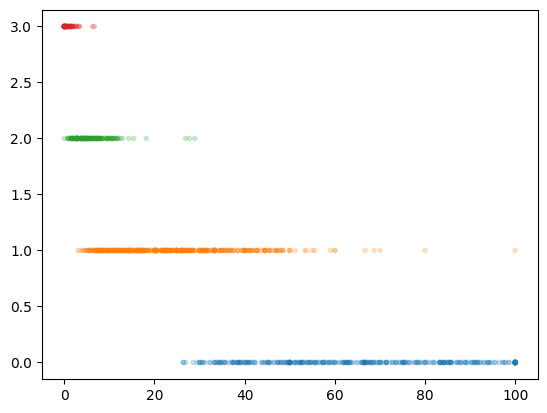

In [ ]:
#plots different difficulties in different colors
#Darker dots means more points are there
plt.scatter(clear_rate_arr, difficulty_codes, marker=".", color=[f"C{x}" for x in difficulty_codes], alpha = 0.2)

In [ ]:
#Plot the count of levels of each difficulty
print("Difficulty: Count")
for i in range(0, 4):
  print(str(i) + ": " + str(level_data_df["difficulty"].value_counts().get(i, 0)))

Difficulty: Count
0: 342
1: 441
2: 154
3: 63


I will use a logistic regression for multiple categories to predict difficulty. The prior for the cutpoints between difficulty ratings uses a constrained dirichlet distribution.

In [ ]:
#Plot the posterior and the posterior predictive check side by side
def PlotTwo(idata):
  #Get posterior
  posterior = idata.posterior
  mu = posterior["θ"].mean(("chain", "draw"))

  #this will help us tanslate from the standardized data back to the raw data
  idx = np.argsort(clear_rate_arr)

  #set up the plot
  fig, axs = plt.subplots(1, 2, figsize=(20, 6))
  axs = axs.flatten()
  ax = axs[0]

  #plot the posterior
  ax.plot(clear_rate_arr[idx], mu[idx], color="C0", lw=2)
  ax.hlines(posterior["cutpoints"].mean(("chain", "draw")), 0, 100, color="C2", zorder=0)

  #Plot cutpoints
  cutpoints_hdi = az.hdi(posterior["cutpoints"])
  for i in range(0, len(cutpoints_hdi["cutpoints"])):
    ax.fill_between([0, 100], cutpoints_hdi["cutpoints"][i][0], cutpoints_hdi["cutpoints"][i][1], color="C2", alpha=0.6, lw=0)

  #scatter plot of raw data
  ax.scatter(clear_rate_arr, difficulty_codes, marker=".", color=[f"C{x}" for x in difficulty_codes], alpha = 0.2)

  #plots the sigmoid regression
  az.plot_hdi(clear_rate_arr, posterior["θ"], color="C0", ax=ax, fill_kwargs={"lw": 0})

  #labels
  ax.set_xlabel('clear rate')
  ax.set_ylabel("θ", rotation=0)

  # use original scale for xticks
  locs, fig = plt.xticks()

  ax.set_title("Posterior")
  axs[1].set_title("Posterior Predictive Checks")
  az.plot_ppc(idata, ax=axs[1])
  plt.show()


In [ ]:
#Function to specify a prior over the cutpoints in the predicted variable by Dr. Ben Vincent and Adrian Seyboldt
def constrainedUniform(N, min=0, max=1):
    return pm.Deterministic(
        "cutpoints",
        pt.concatenate(
            [
                np.ones(1) * min,
                pt.extra_ops.cumsum(pm.Dirichlet("cuts_unknown", a=np.ones(N - 2))) * (max - min) + min,
            ]
        ),
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/jax/_src/interpreters/mlir.py:1081: UserWarning: Some donated buffers were not usable: ShapedArray(float64[2,1000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Output()

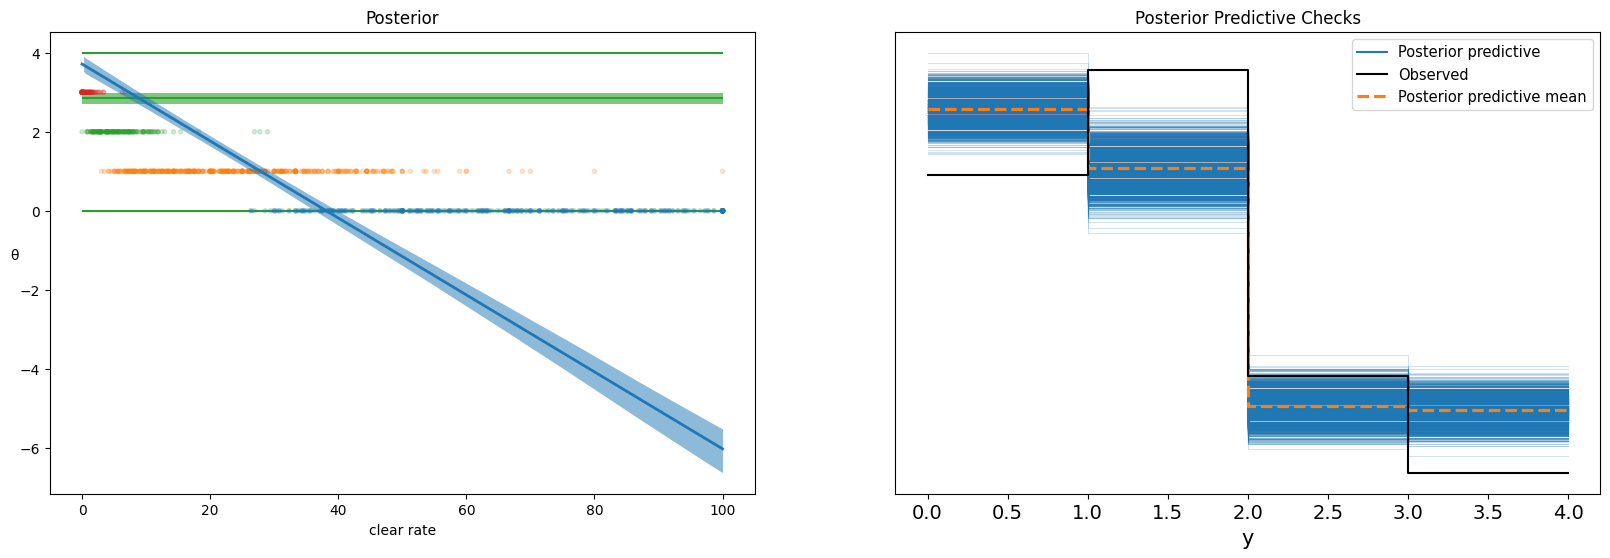

In [ ]:
with pm.Model() as difficulty_model:
    #Priors
    cutpoints = constrainedUniform(4, 0, 4)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * clear_rate_arr
    θ = pm.Deterministic("θ", μ)

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=θ, observed=difficulty_codes)

    idata_difficulty = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty.extend(pm.sample_posterior_predictive(idata_difficulty))
PlotTwo(idata_difficulty)

The posterior predictive check's mean prediction line does not match the observed difficulty data, and the individual predictions shown are are far from the observed line for easy, normal, and super expert levels, so this model's predictions are poor. The posterior mean line of the model does not match the curved shape of the level data, so a straight line is likely not the best method to capture the relationship between difficulty and clear rate. To better match the shape of the data, an exponential transformation will be tried in the next model.
Additionally, for clarification, the clear rate at the points where the green markers intersect the blue mean line should be the cutpoints between difficulties.

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/jax/_src/interpreters/mlir.py:1081: UserWarning: Some donated buffers were not usable: ShapedArray(float64[2,1000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Output()

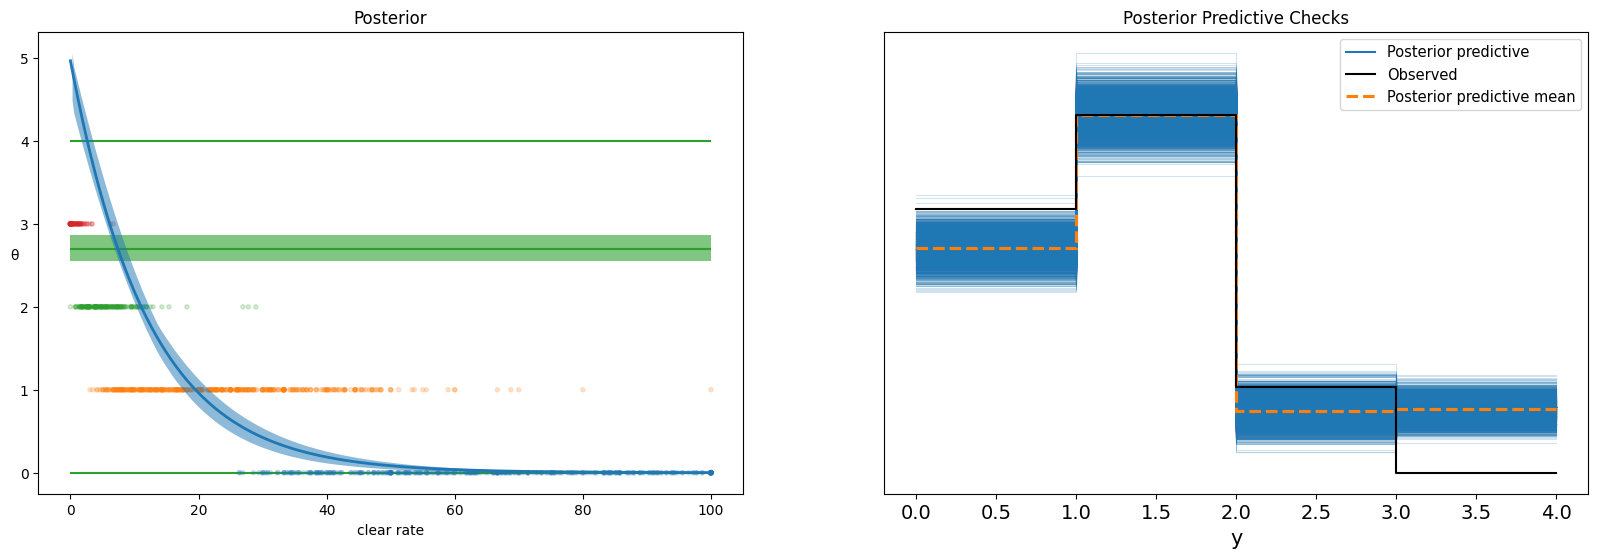

In [ ]:
with pm.Model() as difficulty_model_exp:
    #Priors
    cutpoints = constrainedUniform(4, 0, 4)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * clear_rate_arr
    θ = pm.Deterministic("θ", np.exp(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=θ, observed=difficulty_codes)

    idata_difficulty_exp = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_exp.extend(pm.sample_posterior_predictive(idata_difficulty_exp))
PlotTwo(idata_difficulty_exp)

This mean line matches the curved appearance of the data much better than the straight line one. The posterior predictive check also indicates a model capable of better predictions than the straight line one. The normal difficulty column's posterior predictive mean is extremely close to the observed data, and the easy and expert difficulty predictions overlap the observations. However, this overlap is slight, and the super expert level predictions are not close to the data. While this model is better than the last, it is not close to perfect. Next, a logarithmic tranformation will be applied in place of the exponential one.

In [ ]:
with pm.Model() as difficulty_model_log:
    #Priors
    cutpoints = constrainedUniform(4, 0, 4)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * clear_rate_arr
    θ = pm.Deterministic("θ", np.log(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=θ, observed=difficulty_codes)

    idata_difficulty_log = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_log.extend(pm.sample_posterior_predictive(idata_difficulty_log))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/mlir.py:1081: UserWarning: Some donated buffers were not usable: ShapedArray(float64[2,1000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"
ERROR:pymc.stats.convergence:There were 620 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

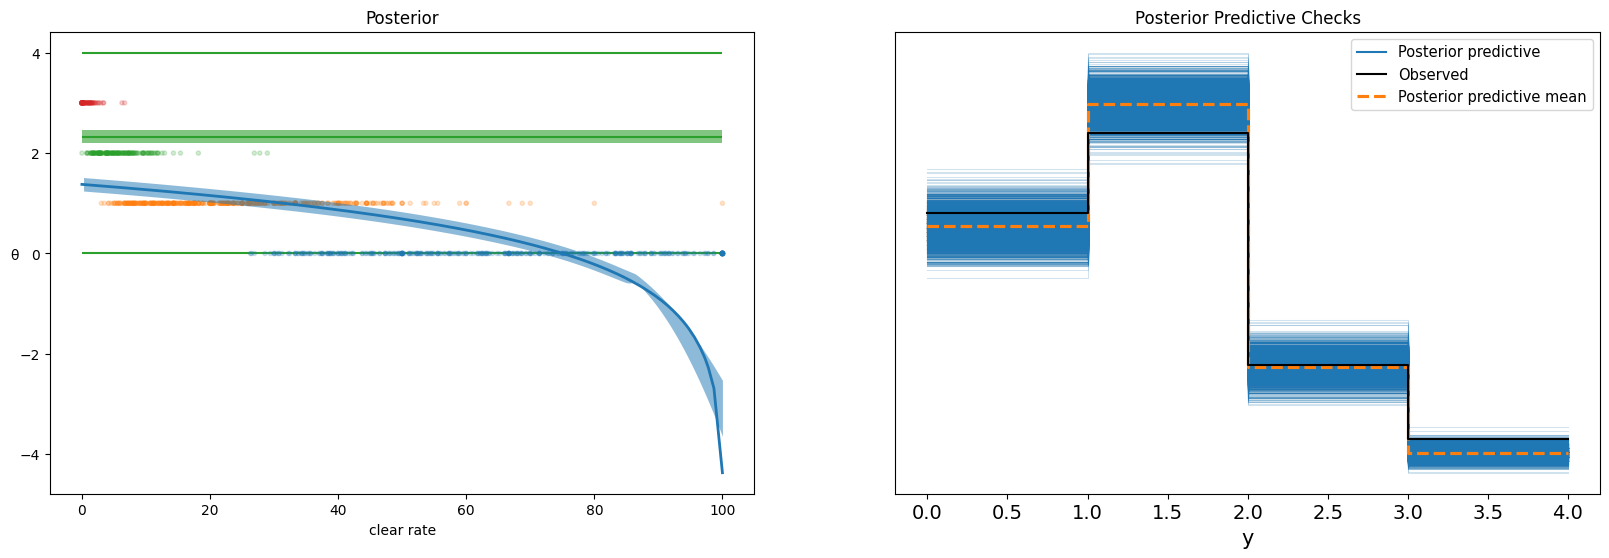

In [ ]:
PlotTwo(idata_difficulty_log)

Though the posterior mean line initially seems like a much stranger shape in relation to the shape of the data, the posterior predictive check shows this log model's predictions capture the observed data line for every difficulty type. Interestingly, the log model's posterior predictive check mean captures the expert level data very well, while the exponential model best captured the normal levels. The last type of transformation tested will be that of a sigmoid function.

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/jax/_src/interpreters/mlir.py:1081: UserWarning: Some donated buffers were not usable: ShapedArray(float64[2,1000,1]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Output()

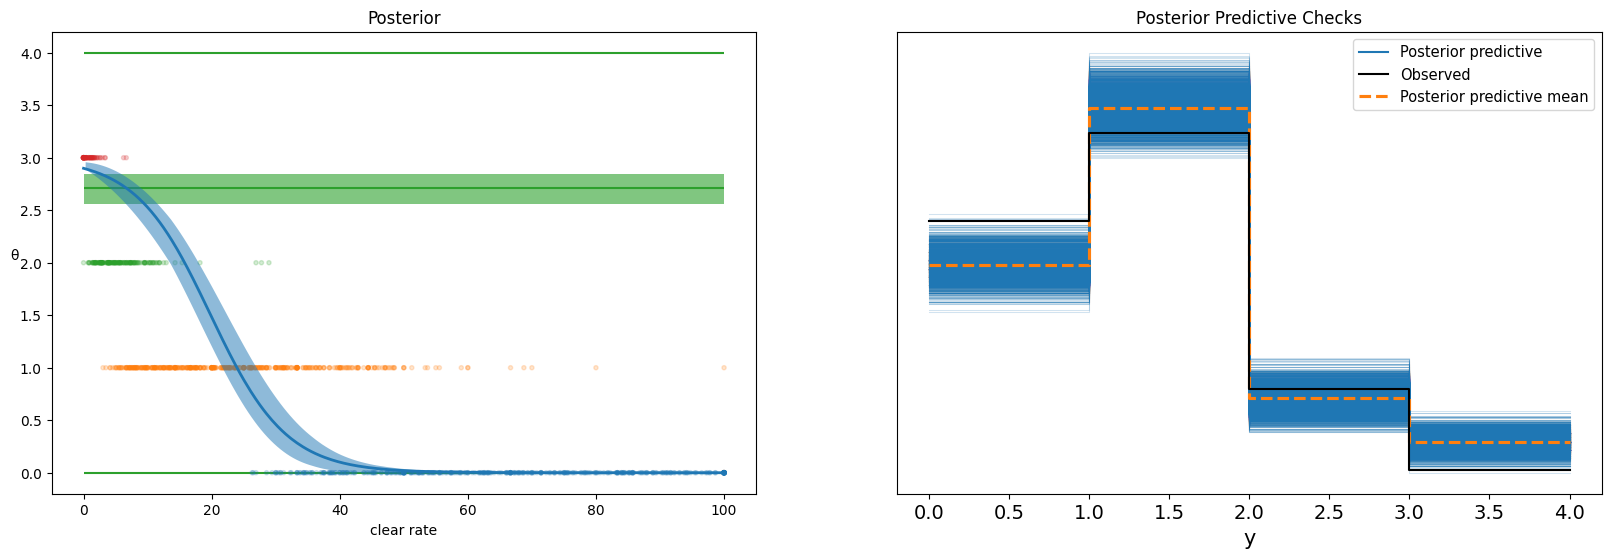

In [ ]:
with pm.Model() as difficulty_model_sig:
    #Priors
    cutpoints = constrainedUniform(4, 0, 4)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * clear_rate_arr
    θ = pm.Deterministic("θ", 3 * pm.math.sigmoid(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=θ, observed=difficulty_codes)

    idata_difficulty_sig = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_sig.extend(pm.sample_posterior_predictive(idata_difficulty_sig))
PlotTwo(idata_difficulty_sig)

The posterior mean sigmoid curve appears to match the data shape well, yet the posterior predictive check mean line and prediction lines do not approximate the observed data as well as the log model. Next, additional visualizations will be created from the log model, as that is the best one thus far. A visual for the model hierarchy will be displayed, followed by a graph of the probability that a particular level from the data will be each difficulty based on its clear rate.

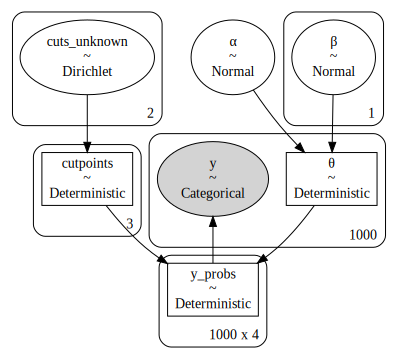

In [ ]:
#Visualize the model hierarchy
pm.model_to_graphviz(difficulty_model_log)

Below, we can visualize the difficulty prediction of a certain level from the data based on its clear rate. The probability of each difficulty by intervals plotted.

In [ ]:
implied_probs = az.extract(idata_difficulty_log, var_names=["y_probs"])
implied_probs.shape

(1000, 4, 2000)

In [ ]:
implied_probs[0].mean(axis=1)

<xarray.DataArray 'y_probs' (y_probs_dim_1: 4)> Size: 32B
array([0.2286375 , 0.52189447, 0.19112903, 0.058339  ])
Coordinates:
    y_probs_dim_0  int64 8B 0
  * y_probs_dim_1  (y_probs_dim_1) int64 32B 0 1 2 3

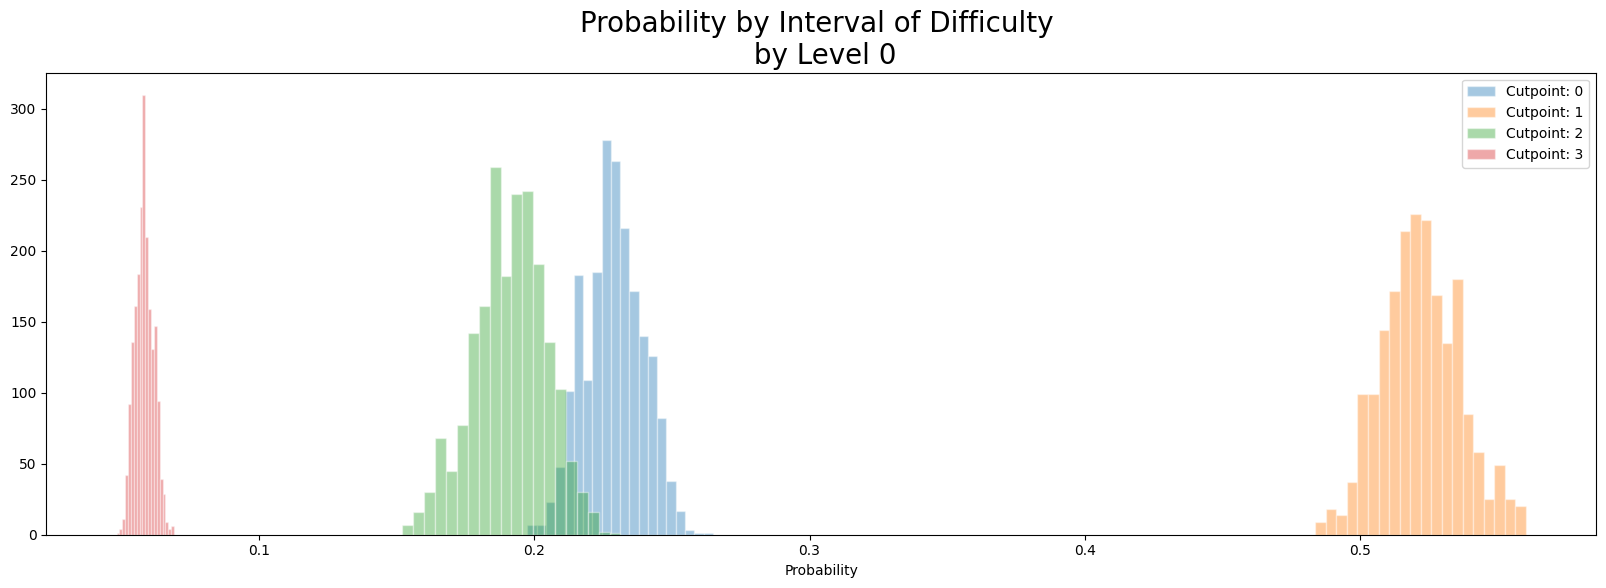

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
for i in range(len(level_data_df["difficulty"].unique())):
    ax.hist(implied_probs[0, i, :], label=f"Cutpoint: {i}", ec="white", bins=20, alpha=0.4)
ax.set_xlabel("Probability")
ax.set_title("Probability by Interval of Difficulty \n by Level 0", fontsize=20)
ax.legend();

The above graph shows a level that is most likely a normal level and is quite unlikely to be a super expert one.

The next point of oddity among the previous models that will be addressed to find a better model is the nature of the cutpoints. The models have each been very certain that the cutpoint between easy and normal lies at the zero difficulty mark and that the cutpoint between expert and super expert lies at the four difficulty mark. The cutpoint lines not appearing between each difficulty categorization seems odd, as well as the fact that four does not correspond to a valid difficulty.

Two additional cutpoints will be added to each model to see if the extra cutpoints align in a more visually sensical way with the plotted data.

The other change that will be explored is setting the maximum cutpoint value to three, the max difficulty in the data, rather than four, where the third cutpoint has been appearing.

These cutpoint-based variations yield a large number of models that do not yield many particularly interesting new observations. These can be viewed in the "Further Models" section of this notebook. Only one model did as well as the original log model discussed above. This was a sigmoid model with two extra cutpoints which is shown below.

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/mlir.py:1081: UserWarning: Some donated buffers were not usable: ShapedArray(float64[2,1000,3]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Output()

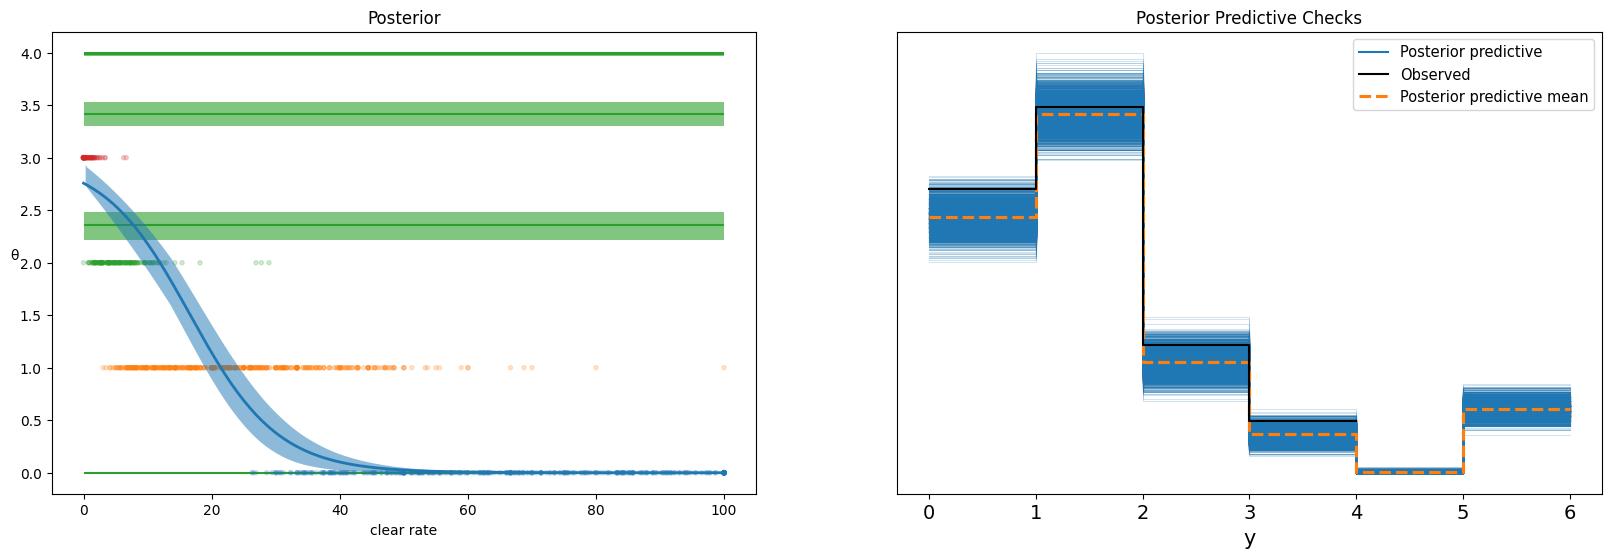

In [ ]:
with pm.Model() as difficulty_model_sig_c:
    #Priors
    cutpoints = constrainedUniform(6, 0, 4)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * clear_rate_arr
    θ = pm.Deterministic("θ", 3 * pm.math.sigmoid(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=θ, observed=difficulty_codes)

    idata_difficulty_sig_c = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_sig_c.extend(pm.sample_posterior_predictive(idata_difficulty_sig_c))

PlotTwo(idata_difficulty_sig_c)

This model combines the more sensical posterior mean line shape of the sigmoid transformation with a posterior predictive check about as good as the log model. Given those two factors, I believe this is the best model for clear rate versus difficulty. The cutpoints are still odd, but no model variation made them less so. The tendency of the models to predict super expert categorization to be very unlikely could be a reflection of the low quantity of such levels present in the data.

Ultimately, clear rate may not be the best predictor of difficulty. The generating process for this data is a level classification program that likely has cutpoints hardcoded into it, so it seems strange that there would not be such clear points in the data collected here. While a trend clearly exists between clear rate and difficulty, perhaps the Super Mario Maker 2 engine is using the raw number of clears or a combination of multiple variables to make its difficulty determinations.

Below, in the "Further Models" section, are the other models with variations in cutpoint handling. After that, the final section contains ideas for models that I could not get to run.

# Further Models

In [ ]:
with pm.Model() as difficulty_model_c:
    #Priors
    cutpoints_c = constrainedUniform(7, 0, 4)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * clear_rate_arr
    θ = pm.Deterministic("θ", np.log(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints_c, eta=θ, observed=difficulty_codes)

    idata_difficulty_c = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_c.extend(pm.sample_posterior_predictive(idata_difficulty_c))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/mlir.py:1081: UserWarning: Some donated buffers were not usable: ShapedArray(float64[2,1000,4]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"
ERROR:pymc.stats.convergence:There were 849 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

In [ ]:
#Print alpha, beta, and the cutpoints
az.summary(idata_difficulty_c, var_names=["cutpoints", "α", "β"])

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cutpoints[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
cutpoints[1],1.953,0.075,1.817,2.089,0.004,0.002,455.0,451.0,1.00
cutpoints[2],3.043,0.083,2.888,3.203,0.004,0.003,490.0,423.0,1.01
cutpoints[3],3.961,0.030,3.904,3.999,0.002,0.002,125.0,236.0,1.03
cutpoints[4],3.980,0.021,3.941,4.000,0.001,0.001,100.0,68.0,1.02
cutpoints[5],4.000,0.000,4.000,4.000,0.000,0.000,1681.0,1498.0,1.00
α,3.211,0.220,2.814,3.633,0.013,0.009,300.0,342.0,1.01
β[0],-0.032,0.002,-0.036,-0.028,0.000,0.000,299.0,338.0,1.01


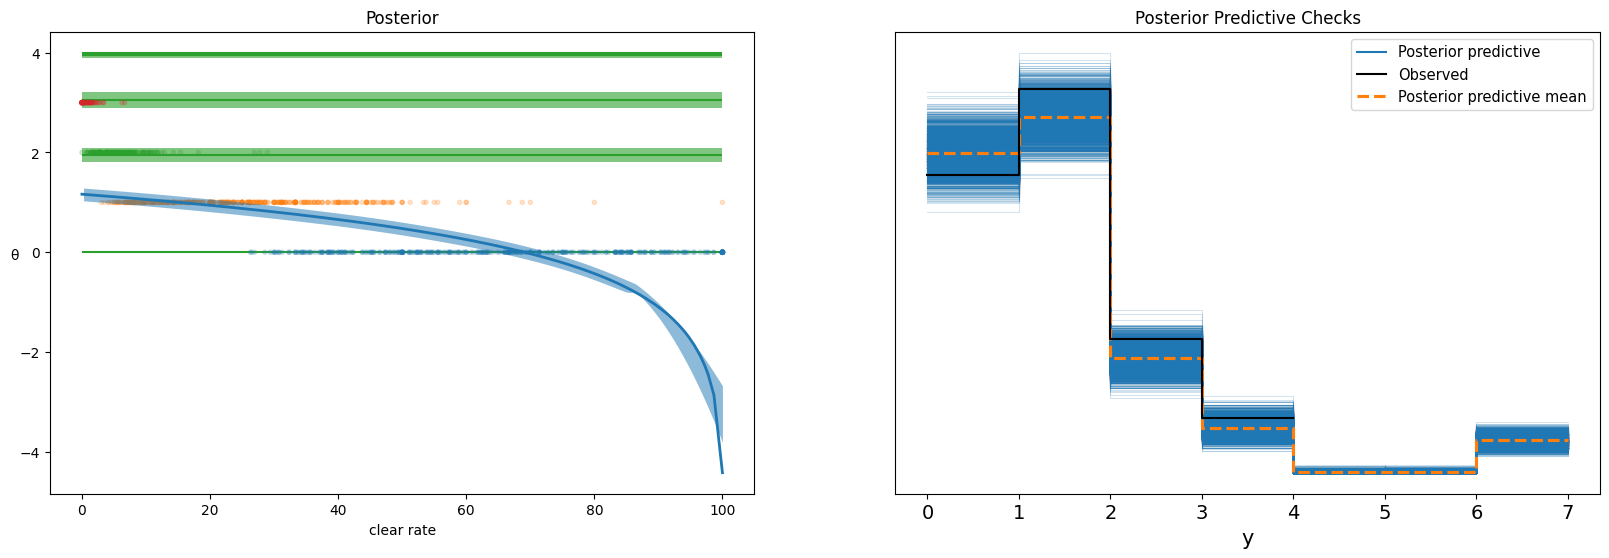

In [ ]:
PlotTwo(idata_difficulty_c)

In [ ]:
with pm.Model() as difficulty_model_exp_c6:
    #Priors
    cutpoints = constrainedUniform(6, 0, 4)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * clear_rate_arr
    θ = pm.Deterministic("θ", np.exp(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=θ, observed=difficulty_codes)

    idata_difficulty_exp_c6 = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_exp_c6.extend(pm.sample_posterior_predictive(idata_difficulty_exp_c6))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/mlir.py:1081: UserWarning: Some donated buffers were not usable: ShapedArray(float64[2,1000,3]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Output()

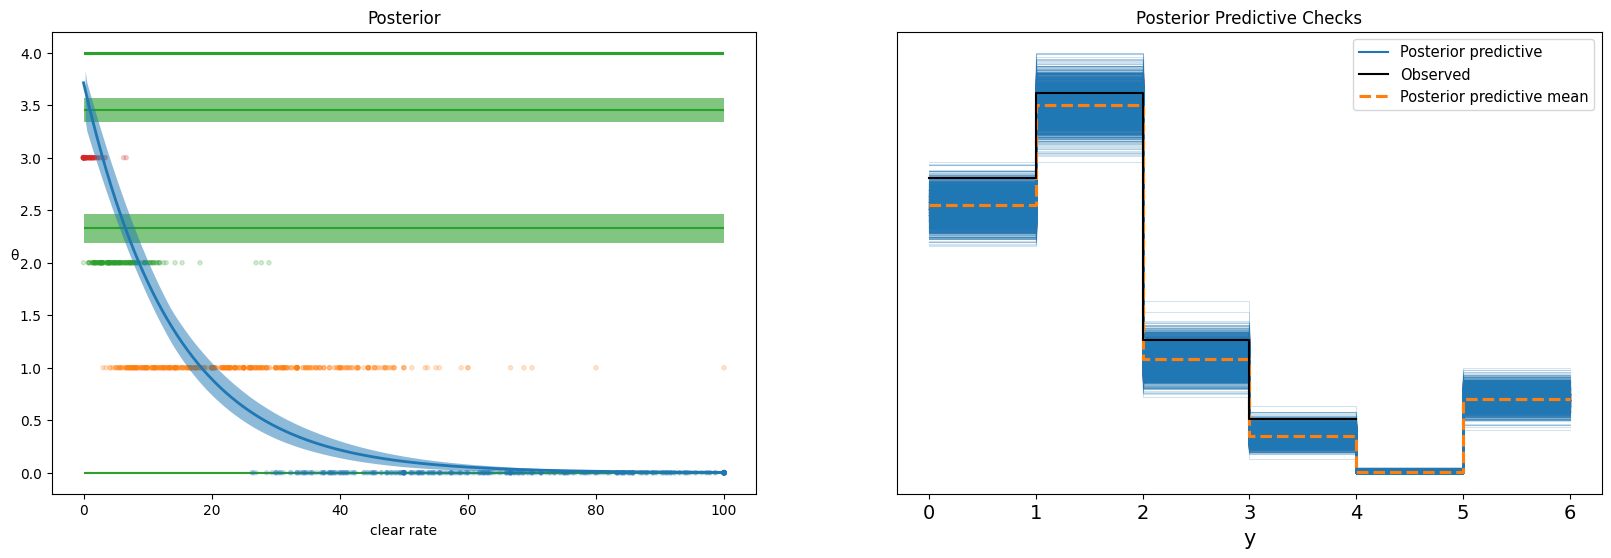

In [ ]:
PlotTwo(idata_difficulty_exp_c6)

In [ ]:
with pm.Model() as difficulty_model_exp_c7:
    #Priors
    cutpoints = constrainedUniform(7, 0, 4)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * clear_rate_arr
    θ = pm.Deterministic("θ", np.exp(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=θ, observed=difficulty_codes)

    idata_difficulty_exp_c7 = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_exp_c7.extend(pm.sample_posterior_predictive(idata_difficulty_exp_c7))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/mlir.py:1081: UserWarning: Some donated buffers were not usable: ShapedArray(float64[2,1000,4]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Output()

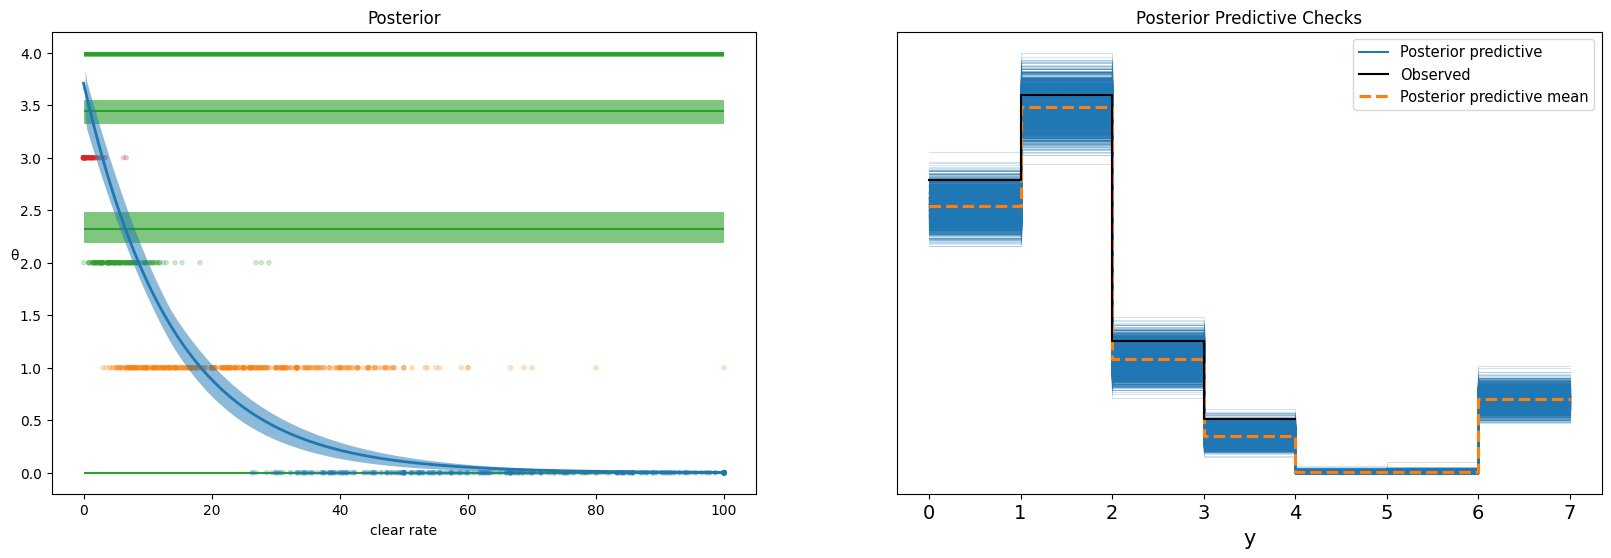

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cutpoints[0],0.000,0.000,0.000,0.000,0.000,0.000,2000.0,2000.0,NaN
cutpoints[1],2.326,0.076,2.191,2.478,0.002,0.001,2026.0,1674.0,1.00
cutpoints[2],3.443,0.061,3.323,3.549,0.001,0.001,2059.0,1487.0,1.00
cutpoints[3],3.982,0.013,3.959,4.000,0.000,0.000,585.0,919.0,1.01
cutpoints[4],3.991,0.009,3.975,4.000,0.000,0.000,858.0,742.0,1.00
cutpoints[5],4.000,0.000,4.000,4.000,0.000,0.000,2101.0,1955.0,1.00
α,1.310,0.041,1.231,1.386,0.001,0.001,967.0,881.0,1.00
β[0],-0.072,0.005,-0.082,-0.062,0.000,0.000,1139.0,1301.0,1.00


In [ ]:
PlotTwo(idata_difficulty_exp_c7)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/mlir.py:1081: UserWarning: Some donated buffers were not usable: ShapedArray(float64[2,1000,3]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"
ERROR:pymc.stats.convergence:There were 628 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

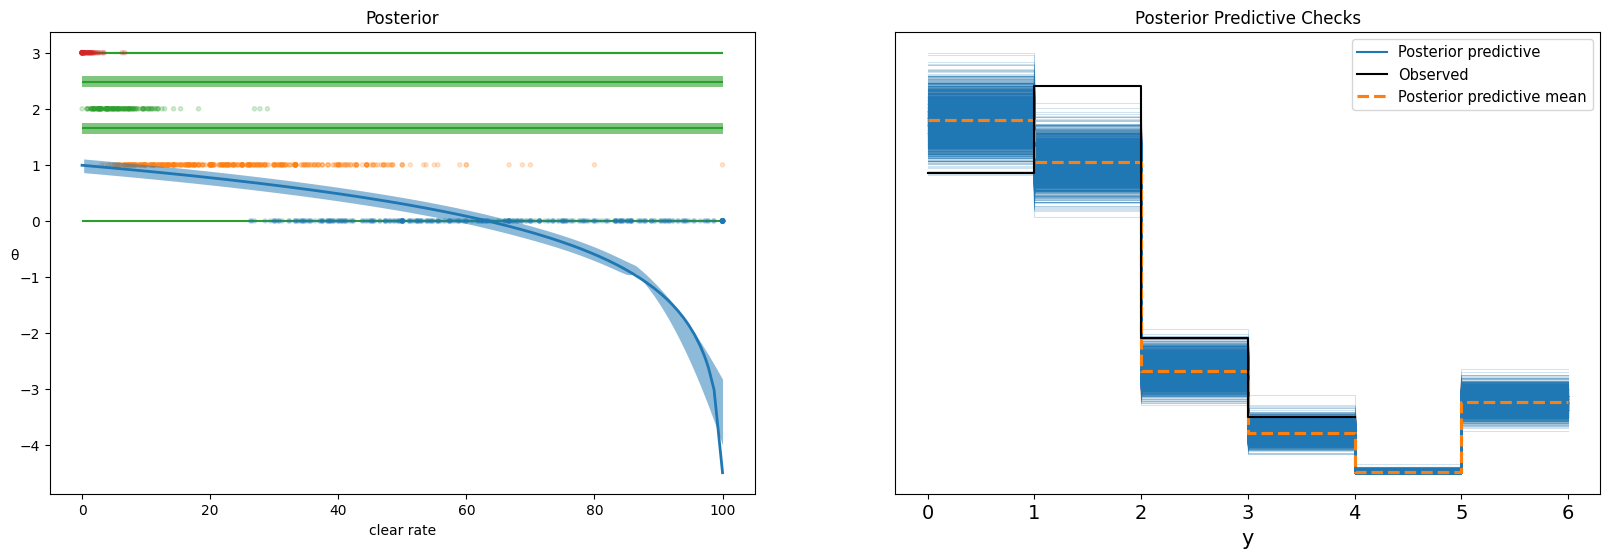

In [ ]:
#llm for log low minimum
with pm.Model() as difficulty_model_llm:
    #Priors
    cutpoints = constrainedUniform(6, 0, 3)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * clear_rate_arr
    θ = pm.Deterministic("θ", np.log(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=θ, observed=difficulty_codes)

    idata_difficulty_llm = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_llm.extend(pm.sample_posterior_predictive(idata_difficulty_llm))
PlotTwo(idata_difficulty_llm)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/mlir.py:1081: UserWarning: Some donated buffers were not usable: ShapedArray(float64[2,1000,3]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Output()

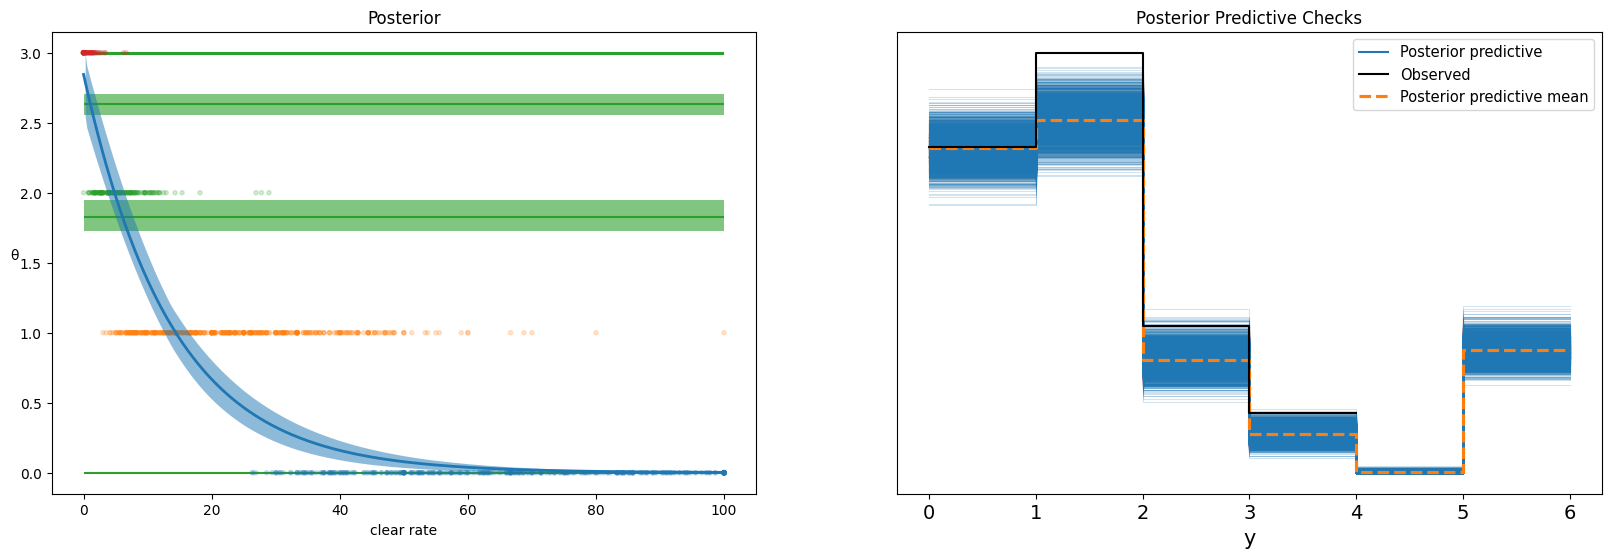

In [ ]:
with pm.Model() as difficulty_model_elm:
    #Priors
    cutpoints = constrainedUniform(6, 0, 3)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * clear_rate_arr
    θ = pm.Deterministic("θ", np.exp(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=θ, observed=difficulty_codes)

    idata_difficulty_elm = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_elm.extend(pm.sample_posterior_predictive(idata_difficulty_elm))
PlotTwo(idata_difficulty_elm)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/mlir.py:1081: UserWarning: Some donated buffers were not usable: ShapedArray(float64[2,1000,3]).
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"


Output()

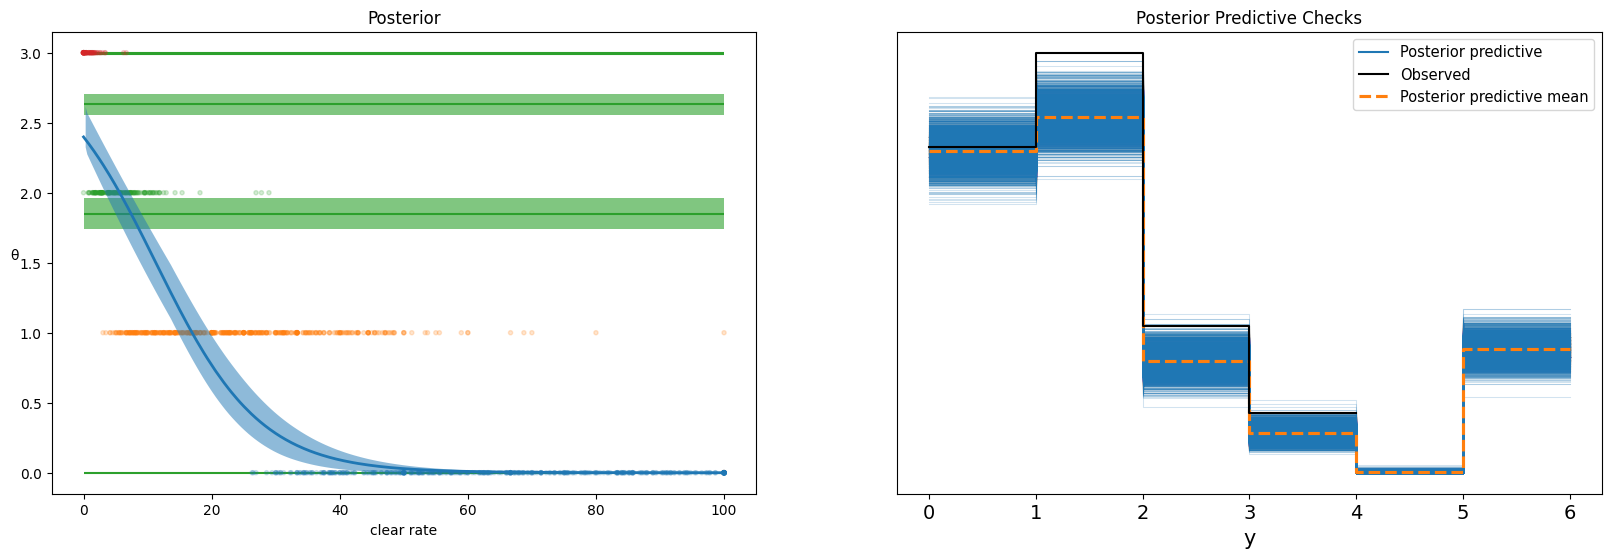

In [ ]:
with pm.Model() as difficulty_model_slm:
    #Priors
    cutpoints = constrainedUniform(6, 0, 3)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * clear_rate_arr
    θ = pm.Deterministic("θ", 3 * pm.math.sigmoid(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=θ, observed=difficulty_codes)

    idata_difficulty_slm = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_slm.extend(pm.sample_posterior_predictive(idata_difficulty_slm))
PlotTwo(idata_difficulty_slm)

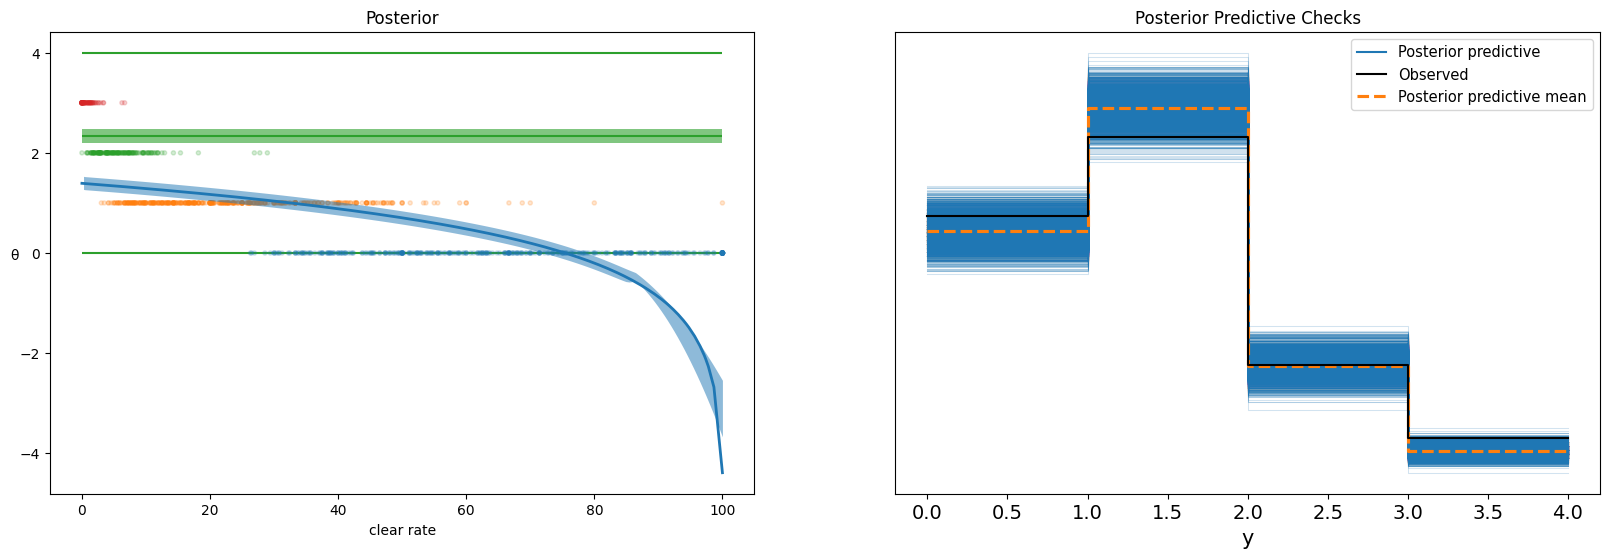

In [ ]:
PlotTwo(idata_difficulty_log)

# Models That Did Not Work

While the pymc example page for ordinal regression suggests categories from 0 to K, the documentation for the ordered logistic likelihood suggests using categories from 1 to K. Here, a value of one will be added to each difficulty in the data. The model attempting to use those incremented difficulties did not run.

In [ ]:
difficulty_plus = difficulty_codes + 1
difficulty_plus

array([2, 2, 2, 1, 1, 2, 1, 4, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2,
       1, 3, 2, 2, 3, 2, 1, 3, 2, 1, 1, 1, 1, 3, 1, 3, 1, 1, 2, 3, 2, 2,
       3, 2, 2, 4, 2, 3, 3, 3, 2, 2, 4, 1, 1, 4, 2, 1, 2, 3, 2, 1, 1, 4,
       3, 2, 2, 3, 2, 2, 1, 1, 3, 2, 2, 1, 2, 3, 1, 1, 2, 4, 4, 2, 2, 3,
       1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 4, 4, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1,
       1, 2, 3, 2, 2, 3, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 3, 4, 1, 3, 1,
       2, 1, 2, 1, 2, 2, 3, 4, 3, 2, 1, 1, 2, 1, 2, 2, 1, 4, 1, 1, 3, 1,
       2, 4, 3, 2, 1, 1, 2, 2, 3, 2, 1, 1, 2, 2, 1, 2, 2, 2, 3, 1, 4, 2,
       1, 2, 2, 2, 2, 3, 1, 4, 2, 2, 1, 1, 4, 1, 3, 2, 3, 1, 3, 4, 2, 1,
       1, 1, 2, 1, 1, 2, 2, 2, 4, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 2, 1,
       2, 4, 1, 1, 2, 3, 1, 2, 2, 1, 4, 2, 3, 1, 2, 3, 2, 2, 1, 3, 3, 1,
       2, 2, 2, 2, 2, 4, 1, 2, 3, 2, 1, 1, 2, 1, 2, 1, 1, 1, 3, 2, 1, 2,
       1, 1, 2, 1, 4, 2, 1, 2, 2, 3, 1, 1, 2, 1, 1, 2, 2, 2, 3, 1, 2, 3,
       1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 3,

In [ ]:
#lp for log plus
with pm.Model() as difficulty_model_lp:
    #Priors
    cutpoints = constrainedUniform(4, 0, 4)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * clear_rate_arr
    θ = pm.Deterministic("θ", np.log(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=θ, observed=difficulty_plus)

    idata_difficulty_lp = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_lp.extend(pm.sample_posterior_predictive(idata_difficulty_lp))
PlotTwo(idata_difficulty_lp)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'cuts_unknown_simplex__': array([0.80063518]), 'α': array(-0.38100206), 'β': array([-0.74308916])}

Logp initial evaluation results:
{'cuts_unknown': -1.28, 'α': -2.31, 'β': -1.2, 'y': -inf}
You can call `model.debug()` for more details.

Here, the data for the clear rate, the difficulty, and both variables were transformed via a log function so that a linear trend might be found involving the tranformed variables. Attempts to create a model with these data transformations failed, though the plots of the data after transformations are shown below.

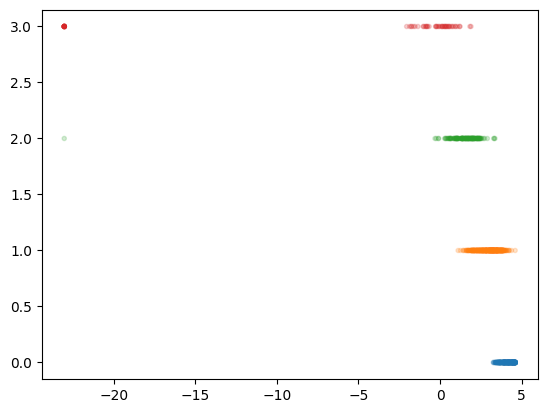

In [ ]:
#Log clear rate
clear_rate_log = np.zeros_like(clear_rate_arr).astype(float)
for i in range(0, len(clear_rate_log)):
  if clear_rate_arr[i] == 0:
    clear_rate_log[i] = np.log(0.0000000001)
  else:
    clear_rate_log[i] = np.log(clear_rate_arr[i])
plt.scatter(clear_rate_log, difficulty_codes, marker=".", color=[f"C{x}" for x in difficulty_codes], alpha = 0.2)

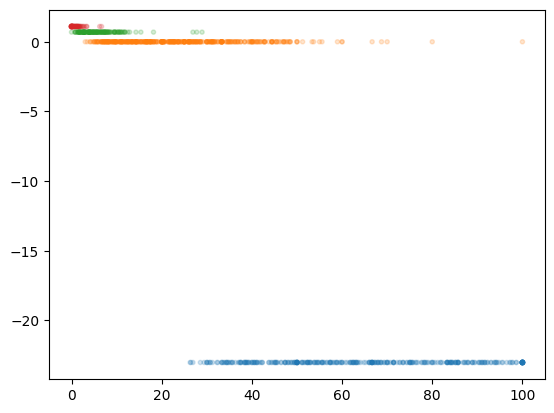

In [ ]:
#Log difficulty
difficulty_log = np.zeros_like(difficulty_codes).astype(float)
for i in range(0, len(difficulty_log)):
  if difficulty_codes[i] == 0:
    difficulty_log[i] = np.log(0.0000000001)
  else:
    difficulty_log[i] = np.log(difficulty_codes[i])
plt.scatter(clear_rate_arr, difficulty_log, marker=".", color=[f"C{x}" for x in difficulty_codes], alpha = 0.2)

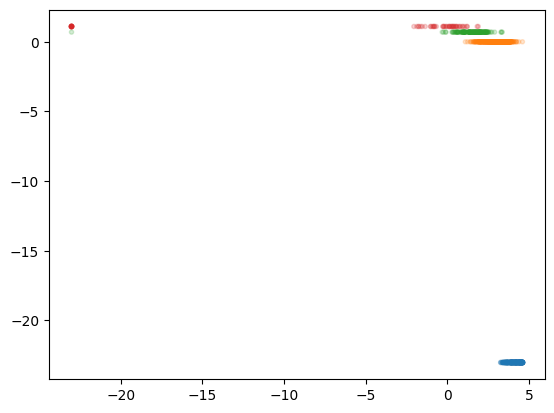

In [ ]:
#Log difficulty and clear rate
plt.scatter(clear_rate_log, difficulty_log, marker=".", color=[f"C{x}" for x in difficulty_codes], alpha = 0.2)

In [ ]:
with pm.Model() as difficulty_model_logdata:
    #Priors
    cutpoints = constrainedUniform(7, 0, 4)
    α = pm.Normal("α", mu=0, sigma=4)
    β = pm.Normal("β", mu=0, sigma=1, size=1)
    #The linear part of the model
    μ = α + β[0] * np.log(clear_rate_arr)
    θ = pm.Deterministic("θ", np.log(μ))

    #likelihood
    y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=θ, observed=difficulty_codes)

    idata_difficulty_ld = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
    idata_difficulty_ld.extend(pm.sample_posterior_predictive(idata_difficulty_ld))

<ipython-input-62-c466981c2ad3>:7: RuntimeWarning: divide by zero encountered in log
  μ = α + β[0] * np.log(clear_rate_arr)


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'cuts_unknown_simplex__': array([ 0.74193099, -0.12535773, -0.11158717, -0.64730186]), 'α': array(0.72834996), 'β': array([-0.24552726])}

Logp initial evaluation results:
{'cuts_unknown': -3.78, 'α': -2.32, 'β': -0.95, 'y': -inf}
You can call `model.debug()` for more details.

In [ ]:
PlotTwo(idata_difficulty_ld)

# Bambi

Using the Bambi library and its example code from [this example page](https://bambinos.github.io/bambi/notebooks/ordinal_regression.html), the ordinal regression analysis was redone. This yielded much more successful results due to Bambi's ability to deterimine the shape of the mean line better than PyMC alone.

First, the data is reprocessed such that one is added to each difficulty value.

In [ ]:
#Read Mario Maker data
mario_levels = load_dataset("TheGreatRambler/mm2_level", streaming=True, split="train")
#Shuffle data
shuffled_levels = mario_levels.shuffle(buffer_size=1_000, seed=75)
#Get the data as a list to iterate over
sample = list(shuffled_levels.take(1000))
#Create a dictionary to hold difficulties anc clear rate
level_data_dict = {"difficulty": [], "clear_rate": []}
#For each element of the list, record the relevant level data
for i in range(0, 1000):
  level_data_dict["difficulty"].append(sample[i]["difficulty"] + 1)
  level_data_dict["clear_rate"].append(sample[i]["clear_rate"])
#Convert the dictionary to a pandas dataframe
level_data_df = pd.DataFrame(level_data_dict)
#Convert difficulty to a category
level_data_df["difficulty"] = pd.Categorical(level_data_df["difficulty"], ordered=True)
#Display the dataframe
level_data_df

Resolving data files:   0%|          | 0/196 [00:00<?, ?it/s]

,difficulty,clear_rate
0,2,14.814815
1,2,26.108374
2,2,9.090909
3,1,81.218274
4,1,77.611940
...,...,...
995,2,22.872340
996,1,56.716418
997,2,23.529412
998,1,33.333333


In [ ]:
level_data_df.difficulty.unique()

[2, 1, 4, 3]
Categories (4, int64): [1 < 2 < 3 < 4]

The probability of each difficulty is plotted.

In [ ]:
pr_k = level_data_df.difficulty.value_counts().sort_index().values / level_data_df.shape[0]
cum_pr_k = np.cumsum(pr_k)
logit_func = lambda x: np.log(x / (1 - x))
cum_logit = logit_func(cum_pr_k)
cum_logit

<ipython-input-13-593c67c1d3a7>:3: RuntimeWarning: divide by zero encountered in divide
  logit_func = lambda x: np.log(x / (1 - x))


array([-0.65439419,  1.28323534,  2.69954856,         inf])

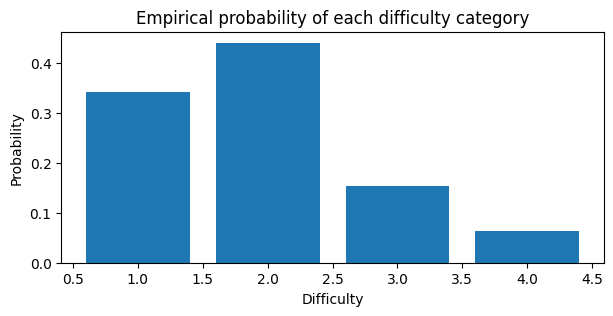

In [ ]:
plt.figure(figsize=(7, 3))
plt.bar(np.arange(1, 5), pr_k)
plt.ylabel("Probability")
plt.xlabel("Difficulty")
plt.title("Empirical probability of each difficulty category");

Next, a model without predictors is created.

Seed: 2025-02-09 03:15:06 UTC Random.org

In [ ]:
bambi_model = bmb.Model("difficulty ~ 0", data=level_data_df, family="cumulative")
bambi_idata = bambi_model.fit(random_seed=340)

Output()

Output()

In [ ]:
bambi_model

       Formula: difficulty ~ 0
        Family: cumulative
          Link: p = logit
  Observations: 1000
        Priors: 
    target = p
        
        
        Auxiliary parameters
            threshold ~ Normal(mu: [-2.  0.  2.], sigma: 1.0, transform: ordered)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [ ]:
az.summary(bambi_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
threshold[0],-0.664,0.067,-0.788,-0.537,0.002,0.001,1869.0,1480.0,1.0
threshold[1],1.273,0.074,1.142,1.417,0.001,0.001,2572.0,1481.0,1.0
threshold[2],2.691,0.128,2.445,2.930,0.002,0.002,2707.0,1630.0,1.0


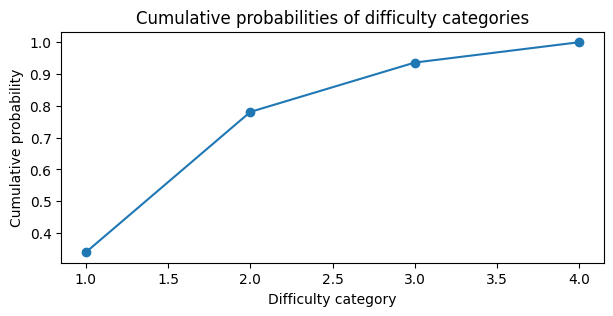

In [ ]:
expit_func = lambda x: 1 / (1 + np.exp(-x))
cumprobs = expit_func(bambi_idata.posterior.threshold).mean(("chain", "draw"))
cumprobs = np.append(cumprobs, 1)

plt.figure(figsize=(7, 3))
plt.plot(sorted(level_data_df.difficulty.unique()), cumprobs, marker='o')
plt.ylabel("Cumulative probability")
plt.xlabel("Difficulty category")
plt.title("Cumulative probabilities of difficulty categories");

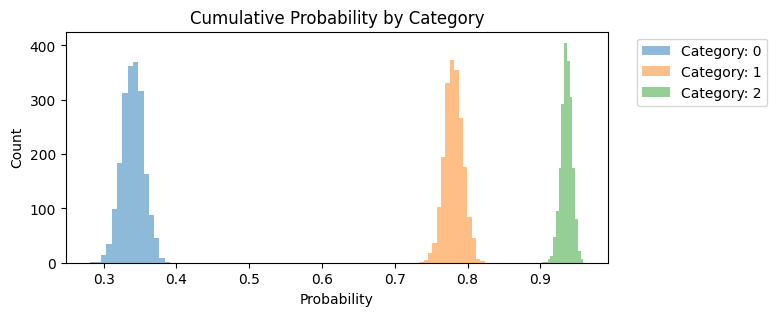

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))
for i in range(3):
    outcome = expit_func(bambi_idata.posterior.threshold).sel(threshold_dim=i).to_numpy().flatten()
    ax.hist(outcome, bins=15, alpha=0.5, label=f"Category: {i}")
ax.set_xlabel("Probability")
ax.set_ylabel("Count")
ax.set_title("Cumulative Probability by Category")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left");

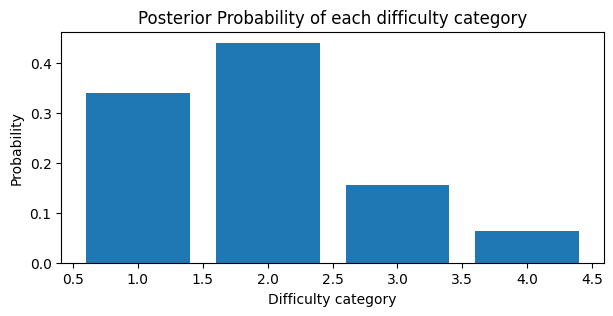

In [ ]:
# derivative
ddx = np.diff(cumprobs)
probs = np.insert(ddx, 0, cumprobs[0])

plt.figure(figsize=(7, 3))
plt.bar(sorted(level_data_df.difficulty.unique()), probs)
plt.ylabel("Probability")
plt.xlabel("Difficulty category")
plt.title("Posterior Probability of each difficulty category");

As can be observed in this posterior probability plot, the model without predictors matches the empirical probabilies very well. For the next bambi model, clear rate will be added.

In [ ]:
bambi_model = bmb.Model(
    "difficulty ~ 0 + clear_rate",
    data=level_data_df,
    family="cumulative"
)
bambi_idata = bambi_model.fit(random_seed=340)

Output()

Output()

In [ ]:
az.summary(
    bambi_idata,
    var_names=["clear_rate"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
clear_rate,-0.178,0.009,-0.194,-0.161,0.0,0.0,663.0,721.0,1.0


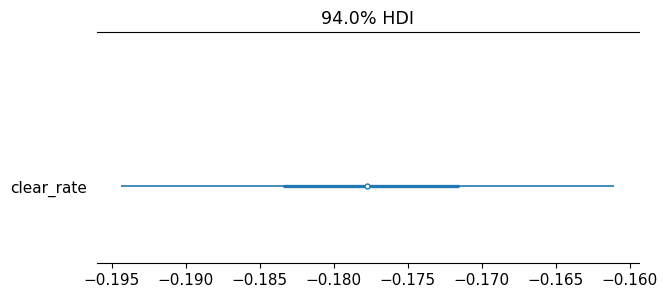

In [ ]:
az.plot_forest(
    bambi_idata,
    combined=True,
    var_names=["clear_rate"],
    figsize=(7, 3),
    textsize=11
);

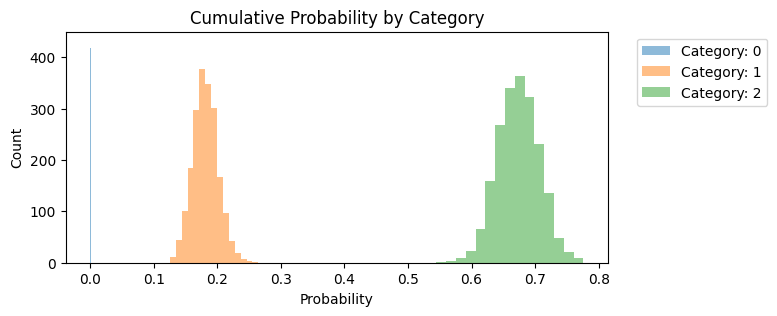

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))
for i in range(3):
    outcome = expit_func(bambi_idata.posterior.threshold).sel(threshold_dim=i).to_numpy().flatten()
    ax.hist(outcome, bins=15, alpha=0.5, label=f"Category: {i}")
ax.set_xlabel("Probability")
ax.set_ylabel("Count")
ax.set_title("Cumulative Probability by Category")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left");

In [ ]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], c[1] * amount, c[2])

def plot_ppc_discrete(idata, bins, ax):

    def add_discrete_bands(x, lower, upper, ax, **kwargs):
        for i, (l, u) in enumerate(zip(lower, upper)):
            s = slice(i, i + 2)
            ax.fill_between(x[s], [l, l], [u, u], **kwargs)

    var_name = list(idata.observed_data.data_vars)[0]
    y_obs = idata.observed_data[var_name].to_numpy()

    counts_list = []
    for draw_values in az.extract(idata, "posterior_predictive")[var_name].to_numpy().T:
        counts, _ = np.histogram(draw_values, bins=bins)
        counts_list.append(counts)
    counts_arr = np.stack(counts_list)

    qts_90 = np.quantile(counts_arr, (0.05, 0.95), axis=0)
    qts_70 = np.quantile(counts_arr, (0.15, 0.85), axis=0)
    qts_50 = np.quantile(counts_arr, (0.25, 0.75), axis=0)
    qts_30 = np.quantile(counts_arr, (0.35, 0.65), axis=0)
    median = np.quantile(counts_arr, 0.5, axis=0)

    colors = [adjust_lightness("C0", x) for x in [1.8, 1.6, 1.4, 1.2, 0.9]]

    add_discrete_bands(bins, qts_90[0], qts_90[1], ax=ax, color=colors[0])
    add_discrete_bands(bins, qts_70[0], qts_70[1], ax=ax, color=colors[1])
    add_discrete_bands(bins, qts_50[0], qts_50[1], ax=ax, color=colors[2])
    add_discrete_bands(bins, qts_30[0], qts_30[1], ax=ax, color=colors[3])


    ax.step(bins[:-1], median, color=colors[4], lw=2, where="post")
    ax.hist(y_obs, bins=bins, histtype="step", lw=2, color="black", align="mid")
    handles = [
        Line2D([], [], label="Observed data", color="black", lw=2),
        Line2D([], [], label="Posterior predictive median", color=colors[4], lw=2)
    ]
    ax.legend(handles=handles)
    return ax

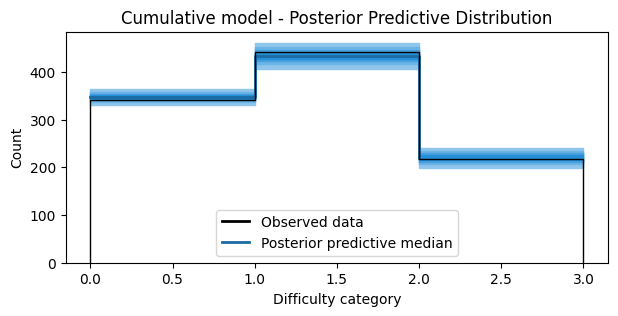

In [ ]:
idata_pps = bambi_model.predict(idata=bambi_idata, kind="response", inplace=False)

bins = np.arange(4)
fig, ax = plt.subplots(figsize=(7, 3))
ax = plot_ppc_discrete(idata_pps, bins, ax)
ax.set_xlabel("Difficulty category")
ax.set_ylabel("Count")
ax.set_title("Cumulative model - Posterior Predictive Distribution");

This is the best posterior predictive check by far of any model. Each posterior predictive median aligns with the observed data and the predictions do not vary far off of the observed lines. This model's predictions can be trusted.

In [ ]:
bambi_model

       Formula: difficulty ~ 0 + clear_rate
        Family: cumulative
          Link: p = logit
  Observations: 1000
        Priors: 
    target = p
        Common-level effects
            clear_rate ~ Normal(mu: 0.0, sigma: 0.0879)
        
        Auxiliary parameters
            threshold ~ Normal(mu: [-2.  0.  2.], sigma: 1.0, transform: ordered)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


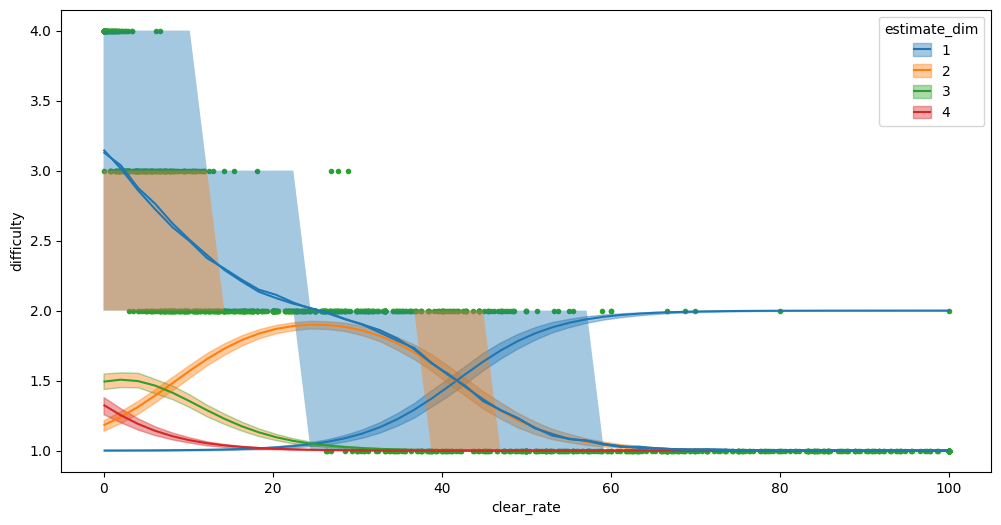

In [ ]:
#Plot two HDIs
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
#mean line
bmb.interpret.plot_predictions(bambi_model, bambi_idata, "clear_rate", ax=ax, fig_kwargs={"color":"k"}, transforms={"difficulty":lambda x: x+1})
#94% HDI
bmb.interpret.plot_predictions(bambi_model, bambi_idata, "clear_rate", pps=True, ax=ax, transforms={"difficulty":lambda x: x+1})
#65% HDI
ax_ = bmb.interpret.plot_predictions(bambi_model, bambi_idata, "clear_rate", pps=True, ax=ax, prob=0.65, transforms={"difficulty":lambda x: x+1})
ax_[1][0].get_children()[5].set_facecolor('C1')

#raw data
ax.plot(level_data_df.clear_rate, level_data_df.difficulty, "C2.", zorder=-3)

By constructing its own line fitted to a different curve for each difficulty interval, Bambi successfully captures the trend in the data.